In [1]:
# Data Processing
import pandas as pd
from PIL import Image
from examples.generator import generate_balanced_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# LTN
from nltk.sem.logic import Expression
from ltn_imp.automation.knowledge_base import KnowledgeBase
from ltn_imp.automation.data_loaders import LoaderWrapper

## Data Processing

In [2]:
data = pd.DataFrame(generate_balanced_dataset(100))

In [3]:
image_paths = [item for item in data[0]]
images = []
for path in image_paths:
    try:
        img = Image.open(path).convert('RGB')  # Convert to RGB to ensure consistency
        img = np.array(img)
        img_tensor = torch.tensor(img, dtype=torch.float32)  # Convert to PyTorch tensor
        images.append(img_tensor)
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        
labels = torch.tensor(data[1], dtype=torch.float32)

In [4]:
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        # Convert the list of images to a tensor and permute dimensions to [batch_size, channels, height, width]
        self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])
        self.labels = torch.tensor(labels).float()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label
    
batch_size = 25

# Split the data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(images,labels, test_size=0.2, random_state=42)

# Create the training dataset
train_dataset = ImageDataset(train_data, train_labels)

# Create the test dataset
test_dataset = ImageDataset(test_data, test_labels)

# Create the training dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_58728/3823677747.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])
/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_58728/3823677747.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels).float()


<Axes: xlabel='0'>

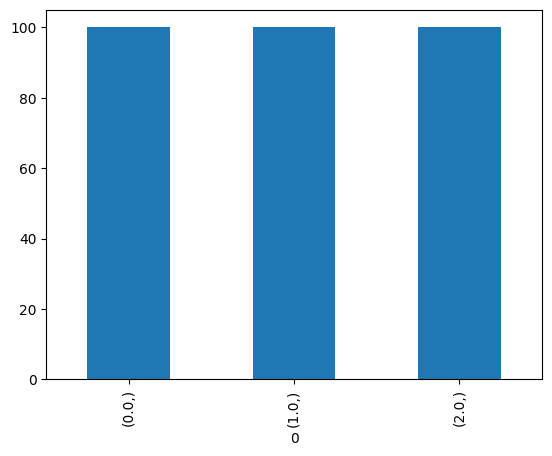

In [5]:
pd.DataFrame(labels).value_counts().plot(kind='bar')

In [6]:
print(f"Number of training images: {len(train_data)}")
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of test images: {len(test_data)}")
print(f"Number of test labels: {len(test_labels)}")

Number of training images: 240
Number of training labels: 240
Number of test images: 60
Number of test labels: 60


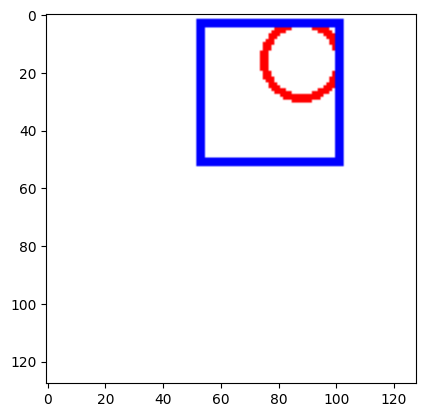

In [7]:
plt.imshow(train_data[0].numpy().astype(np.uint8))

## Models

In [8]:
class CircleDetector(nn.Module):
    def __init__(self):
        super(CircleDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(in_features=128, out_features=3)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        c_x, c_y, r = torch.tanh(x[:, 0]), torch.tanh(x[:, 1]), torch.sigmoid(x[:, 2])
        return c_x, c_y, r

In [9]:
class RectangleDetector(torch.nn.Module):
    def __init__(self):
        super(RectangleDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(in_features=128, out_features=4)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        t_x, t_y,b_x, b_y = torch.tanh(x[:, 0]), torch.tanh(x[:, 1]), torch.tanh(x[:, 2]), torch.tanh(x[:, 3])
        return t_x, t_y, b_x, b_y

## Rules

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Inside(nn.Module):
    def __init__(self):
        super(Inside, self).__init__()

    def forward(self, c1, c2, r, xbl, ybl, xtr, ytr):
        smooth_lt_xbl = torch.sigmoid(10 * (c1 - (xbl + r)))
        smooth_gt_xtr = torch.sigmoid(10 * ((xtr - r) - c1))
        smooth_lt_ybl = torch.sigmoid(10 * (c2 - (ybl + r)))
        smooth_gt_ytr = torch.sigmoid(10 * ((ytr - r) - c2))
        return smooth_lt_xbl * smooth_gt_xtr * smooth_lt_ybl * smooth_gt_ytr

    def __call__(self, *args):
        return self.forward(*args)

class Outside(nn.Module):
    def __init__(self):
        super(Outside, self).__init__()

    def forward(self, c1, c2, r, xbl, ybl, xtr, ytr):
        smooth_gt_xbl = torch.sigmoid(10 * ((xbl - r) - c1))
        smooth_lt_xtr = torch.sigmoid(10 * (c1 - (xtr + r)))
        smooth_gt_ybl = torch.sigmoid(10 * ((ybl - r) - c2))
        smooth_lt_ytr = torch.sigmoid(10 * (c2 - (ytr + r)))
        return smooth_gt_xbl + smooth_lt_xtr + smooth_gt_ybl + smooth_lt_ytr - \
               smooth_gt_xbl * smooth_lt_xtr * smooth_gt_ybl * smooth_lt_ytr

    def __call__(self, *args):
        return self.forward(*args)

class Intersect(nn.Module):
    def __init__(self):
        super(Intersect, self).__init__()

    def forward(self, c1, c2, r, xbl, ybl, xtr, ytr):
        smooth_lt_xbl = torch.sigmoid(10 * (c1 + r - xbl))
        smooth_gt_xtr = torch.sigmoid(10 * (xtr - (c1 - r)))
        smooth_lt_ybl = torch.sigmoid(10 * (c2 + r - ybl))
        smooth_gt_ytr = torch.sigmoid(10 * (ytr - (c2 - r)))
        return smooth_lt_xbl * smooth_gt_xtr * smooth_lt_ybl * smooth_gt_ytr

    def __call__(self, *args):
        return self.forward(*args)

In [11]:
def compute_accuracy(circle_model, rect_model, inside_model, outside_model, intersect_model, test_dataloader, device):
    # Set models to evaluation mode
    circle_model.eval()
    rect_model.eval()
    inside_model.eval()
    outside_model.eval()
    intersect_model.eval()
    
    correct = 0
    total = 0

    class_correct = [0, 0, 0]
    class_total = [0, 0, 0]

    with torch.no_grad():
        for batch_idx, (img_batch, label_batch) in enumerate(test_dataloader):
            img_batch, label_batch = img_batch.to(device), label_batch.to(device)
            
            # Predict the circle parameters
            c_x, c_y, r = circle_model(img_batch)
            
            # Get the bounding box for the true circle
            t11, t12, b11, b12 = rect_model(img_batch)
            
            for i in range(len(img_batch)):
                # Extract the true one-hot encoded label
                true_class = int(label_batch[i].item())
                
                # Compute probabilities for being inside, outside, and intersecting
                inside_prob = inside_model(c_x[i], c_y[i], r[i], t11[i], t12[i], b11[i], b12[i])
                outside_prob = outside_model(c_x[i], c_y[i], r[i], t11[i], t12[i], b11[i], b12[i])
                intersect_prob = intersect_model(c_x[i], c_y[i], r[i], t11[i], t12[i], b11[i], b12[i])
                
                # Stack probabilities to form a tensor
                class_probs = torch.tensor([inside_prob, intersect_prob, outside_prob], device=device)
                predicted_class = torch.argmax(class_probs).item()
                
                # Update overall accuracy
                if predicted_class == true_class:
                    correct += 1
                    class_correct[true_class] += 1
                class_total[true_class] += 1
                total += 1

    accuracy = correct / total
    class_accuracies = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(3)]
    
    # Debug: print class-wise accuracies
    for i, class_acc in enumerate(class_accuracies):
        print(f"Accuracy for class {i}: {class_acc * 100:.2f}%")
    print(f"Overall accuracy: {accuracy * 100:.2f}%")
    
    # Set models back to training mode
    circle_model.train()
    rect_model.train()
    inside_model.train()
    outside_model.train()
    intersect_model.train()

    return accuracy, class_accuracies

## Training

In [12]:
ancillary_rules = [
    "forall xcenter ycenter radius xbottomleft ybottomleft xtopright ytopright. in(xcenter, ycenter, radius, xbottomleft, ybottomleft, xtopright, ytopright) <-> ((xbottomleft + radius <= xcenter and xcenter <= xtopright - radius) and (ybottomleft + radius <= ycenter and ycenter <= ytopright - radius))",
    "forall xcenter ycenter radius xbottomleft ybottomleft xtopright ytopright. intersect(xcenter, ycenter, radius, xbottomleft, ybottomleft, xtopright, ytopright) <-> (xcenter + radius > xbottomleft and xcenter - radius < xtopright and ycenter + radius > ybottomleft and ycenter - radius < ytopright)"
    "forall xcenter ycenter radius xbottomleft ybottomleft xtopright ytopright. out(xcenter, ycenter, radius, xbottomleft, ybottomleft, xtopright, ytopright) <-> (xcenter + radius <= xbottomleft or xcenter - radius >= xtopright or ycenter + radius <= ybottomleft or ycenter - radius >= ytopright)"
]

learning_rules = [
    "all i. ((y = in) -> (Circle(i, c1, c2, r) and Rect(i, t11, t12, b11, b12) and Inside(c1, c2, r, t11, t12, b11, b12)))",
    "all i. ((y = int) -> (Circle(i, c1, c2, r) and Rect(i, t11, t12, b11, b12) and Intersect(c1, c2, r, t11, t12, b11, b12)))",
    "all i. ((y = out) -> (Circle(i, c1, c2, r) and Rect(i, t11, t12, b11, b12) and Outside(c1, c2, r, t11, t12, b11, b12)))"
]

In [13]:
circle = CircleDetector()
rectangle = RectangleDetector()

predicates = {
    "Circle": circle,
    "Rect": rectangle,
    "Inside": Inside(),
    "Outside": Outside(),
    "Intersect": Intersect()
}

loader = LoaderWrapper(loader=train_dataloader, variables=["i"], targets=["y"])

rule_to_loader = {rule: [loader] for rule in learning_rules } 

quantifier_imp = {"forall" : "pmean_error"}

connective_imp = {"eq": "tan"}

constants = { 
    "in" : torch.tensor([0.]),
    "int" : torch.tensor([1.]),
    "out" : torch.tensor([2.]),
}

kb = KnowledgeBase(
    predicates=predicates,
    ancillary_rules=[],
    learning_rules=learning_rules,
    rule_to_data_loader_mapping=rule_to_loader,
    quantifier_impls=quantifier_imp,
    connective_impls=connective_imp,
    constant_mapping=constants
)

[ str(rule) for rule in kb.rules ]

['all i.((y = in) -> (Circle(i,c1,c2,r) & Rect(i,t11,t12,b11,b12) & Inside(c1,c2,r,t11,t12,b11,b12)))',
 'all i.((y = int) -> (Circle(i,c1,c2,r) & Rect(i,t11,t12,b11,b12) & Intersect(c1,c2,r,t11,t12,b11,b12)))',
 'all i.((y = out) -> (Circle(i,c1,c2,r) & Rect(i,t11,t12,b11,b12) & Outside(c1,c2,r,t11,t12,b11,b12)))']

In [21]:
kb.predicates

{'Circle': CircleDetector(
   (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (fc1): Linear(in_features=16384, out_features=128, bias=True)
   (bn_fc1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (fc2): Linear(in_features=128, out_features=3, bias=True)
 ),
 'Rect': RectangleDetector(
   (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv2): Conv2d(16, 32, kernel_size=(3, 3), stri

In [14]:
compute_accuracy(circle,rectangle, Inside(), Outside(), Intersect(), test_dataloader, torch.device("cpu"))

Accuracy for class 0: 0.00%
Accuracy for class 1: 0.00%
Accuracy for class 2: 100.00%
Overall accuracy: 35.00%


(0.35, [0.0, 0.0, 1.0])

In [19]:
kb.optimize(num_epochs=51, lr=0.00001)

['all i.((y = in) -> (Circle(i,c1,c2,r) & Rect(i,t11,t12,b11,b12) & Inside(c1,c2,r,t11,t12,b11,b12)))', 'all i.((y = int) -> (Circle(i,c1,c2,r) & Rect(i,t11,t12,b11,b12) & Intersect(c1,c2,r,t11,t12,b11,b12)))', 'all i.((y = out) -> (Circle(i,c1,c2,r) & Rect(i,t11,t12,b11,b12) & Outside(c1,c2,r,t11,t12,b11,b12)))']
Rule Outputs:  [tensor(0.3748, grad_fn=<RsubBackward1>), tensor(0.6741, grad_fn=<RsubBackward1>), tensor(0.8279, grad_fn=<RsubBackward1>)]
Epoch 1/51, Loss: 0.4190055727958679

['all i.((y = in) -> (Circle(i,c1,c2,r) & Rect(i,t11,t12,b11,b12) & Inside(c1,c2,r,t11,t12,b11,b12)))', 'all i.((y = int) -> (Circle(i,c1,c2,r) & Rect(i,t11,t12,b11,b12) & Intersect(c1,c2,r,t11,t12,b11,b12)))', 'all i.((y = out) -> (Circle(i,c1,c2,r) & Rect(i,t11,t12,b11,b12) & Outside(c1,c2,r,t11,t12,b11,b12)))']
Rule Outputs:  [tensor(0.4430, grad_fn=<RsubBackward1>), tensor(0.6857, grad_fn=<RsubBackward1>), tensor(0.8279, grad_fn=<RsubBackward1>)]
Epoch 11/51, Loss: 0.38237273693084717

['all i.((y 

In [20]:
compute_accuracy(circle,rectangle, Inside(), Outside(), Intersect(), test_dataloader, torch.device("cpu"))

Accuracy for class 0: 0.00%
Accuracy for class 1: 64.71%
Accuracy for class 2: 38.10%
Overall accuracy: 31.67%


(0.31666666666666665, [0.0, 0.6470588235294118, 0.38095238095238093])

In [17]:
kb.declarations

{'c1': tensor([-3.5082e-01,  2.0247e-01,  1.1292e-01, -1.9579e-02, -3.1826e-01,
         -1.1210e-01, -3.4825e-02,  2.2812e-01,  3.0916e-01, -9.4214e-01,
         -3.5792e-01, -1.4809e-01,  3.5579e-01, -9.0827e-01, -6.4533e-02,
         -5.1787e-02,  3.8837e-04,  8.4412e-04, -5.0490e-01,  2.1890e-02,
          3.9112e-01, -9.4129e-01,  1.0268e-01,  4.2760e-01,  2.7320e-01],
        grad_fn=<TanhBackward0>),
 'c2': tensor([-0.8990,  0.3162,  0.1497,  0.9617,  0.7430, -0.6574,  0.0683,  0.5134,
         -0.2523,  0.3736,  0.7956,  0.7912,  0.5369,  0.1776, -0.9306,  0.2786,
          0.2921, -0.1530,  0.6063,  0.3325,  0.4209, -0.0296,  0.5509, -0.8023,
         -0.2316], grad_fn=<TanhBackward0>),
 'r': tensor([0.2358, 0.5766, 0.7455, 0.2484, 0.4016, 0.7337, 0.0825, 0.6648, 0.7436,
         0.5599, 0.4647, 0.5718, 0.4745, 0.3946, 0.3330, 0.4742, 0.5666, 0.5681,
         0.5271, 0.5909, 0.6290, 0.5285, 0.7044, 0.4355, 0.4214],
        grad_fn=<SigmoidBackward0>),
 't11': tensor([-0.8502, 

## Computation Graph 

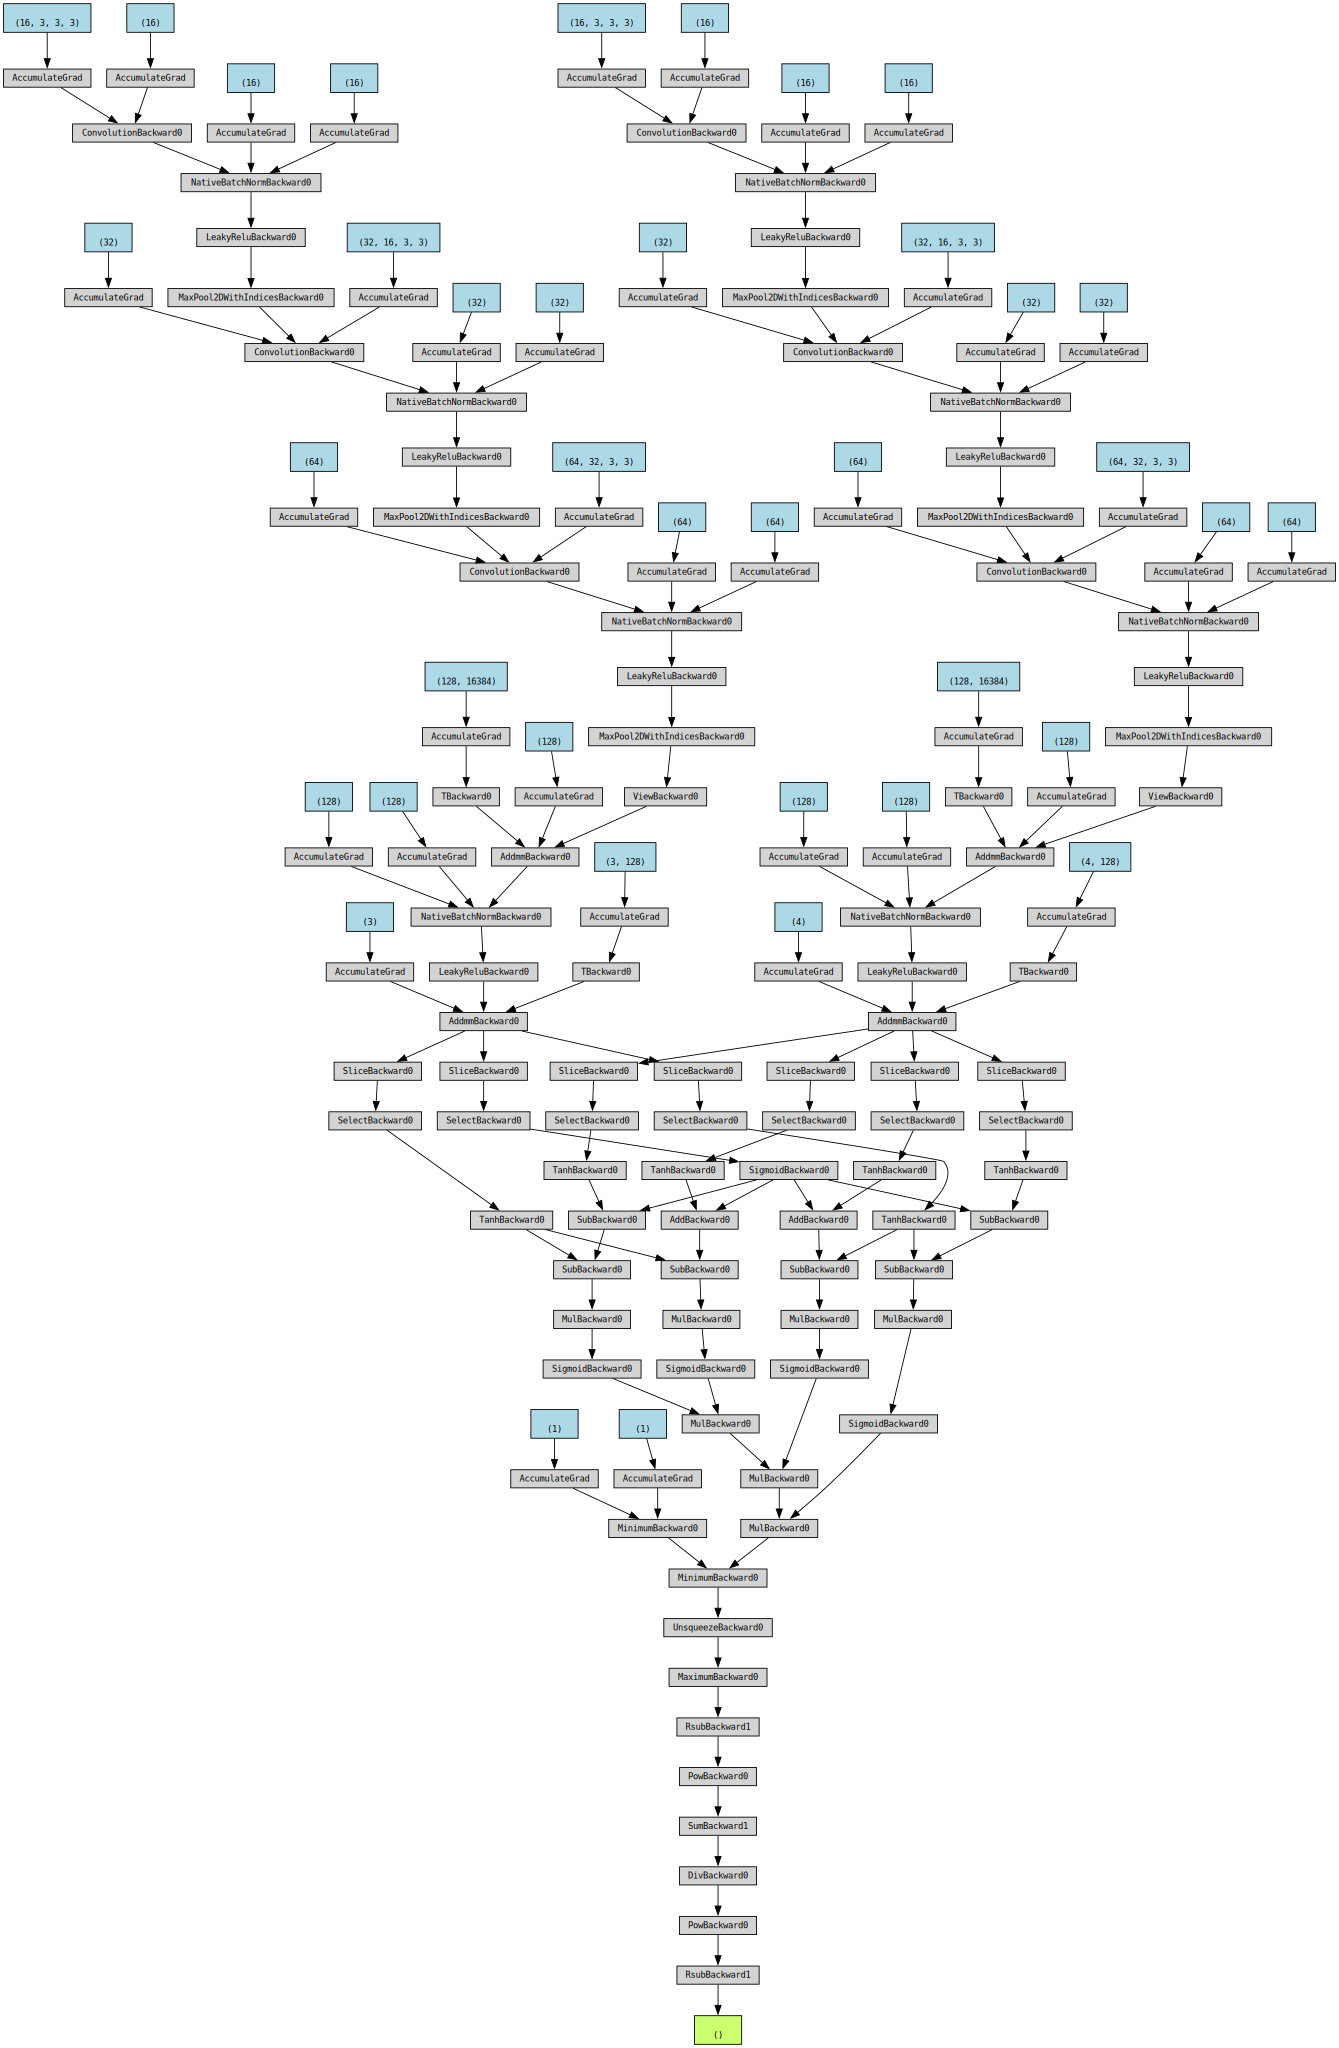

In [18]:
batch = next(iter(test_dataloader))

var_mapping = {}

kb.partition_data(var_mapping,batch, loader )

kb.rules[0].comp_graph(var_mapping)